# Linear Regression / Boston Housing Prices

### Import the Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, learning_curve, ShuffleSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

### Load the Dataset

In [2]:
boston = pd.read_csv('HousingData.csv')

### Perform Basic Maneuvers

In [3]:
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


###### CRIM = Per capita crime rate by town
###### ZN = Proportion of residential land zoned for lots larger than 25,000 square feet
###### INDUS = Proportion of non-retail business acres per town
###### CHAS = Charles River dummy variable (1 if tract borders the river, 0 otherwise)
###### NOX = Concentration (parts per 10 million) of nitric oxide
###### RM = Average number of rooms per dwelling
###### AGE = Proportion of owner-occupied units built prior to 1940
###### DIS = Weighted distances to five Boston employment centers
###### RAD = Index of accessibility to radial highways
###### TAX = Full-value property tax rate per 10,000 dollars
###### PTRATIO = Pupil / Teacher ratio by town
###### B = 1000(Bk - 0.63)^2, where Bk = % of blacks by town
###### LSTAT = % of lower status of the population
###### MEDV = Median value of owner-occupied homes (thousands)

In [4]:
boston.shape

(506, 14)

In [5]:
boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     486 non-null    float64
 1   ZN       486 non-null    float64
 2   INDUS    486 non-null    float64
 3   CHAS     486 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      486 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    486 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [6]:
boston.isnull().sum()

CRIM       20
ZN         20
INDUS      20
CHAS       20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      20
MEDV        0
dtype: int64

###### In the 6 columns that have NULL values, less than 4% of the values are NULL.  In that case, replace the NULL values with the mean of the column.  The only exception is CHAS, which is a dummy column containing only zeroes and ones (any given house either borders the Charles River, or it doesn't, and almost 90% of them don't).  In this case, set the NULL values to zero.

In [7]:
boston['CRIM'] = boston['CRIM'].fillna(boston['CRIM'].mean())
boston['ZN'] = boston['ZN'].fillna(boston['ZN'].mean())
boston['INDUS'] = boston['INDUS'].fillna(boston['INDUS'].mean())
boston['CHAS'] = boston['CHAS'].fillna(0)
boston['AGE'] = boston['AGE'].fillna(boston['AGE'].mean())
boston['LSTAT'] = boston['LSTAT'].fillna(boston['LSTAT'].mean())

### Exploratory Data Analysis

###### Create distribution plots to show skewness.  (Clue #1) The features that are highly-skewed are the least likely to contribute to the prediction of the target variable.  Either the skewness should be fixed, or the feature should be dropped from the model.

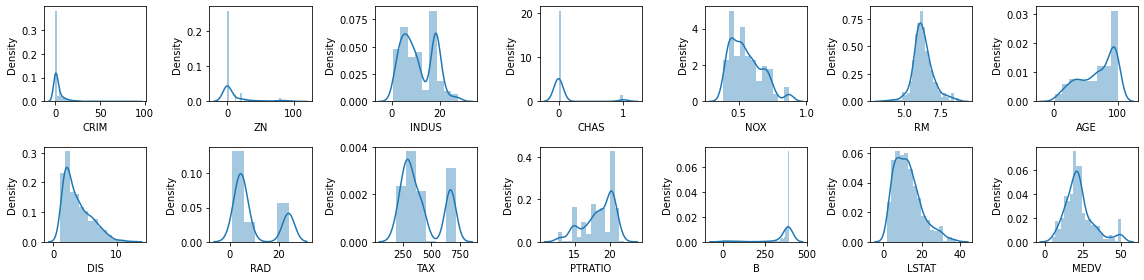

In [8]:
rows = 2
cols = 7
fix, ax = plt.subplots(nrows = rows, ncols = cols, figsize = (16, 4))
col = boston.columns
index = 0
for i in range(rows):
    for j in range(cols):
        sns.distplot(boston[col[index]], ax = ax[i][j])
        index += 1
plt.tight_layout()

###### Create box plots to show outliers.  (Clue #2) Even if a feature is included in the model, outliers have to be dealt with or removed in order to improve model performance.

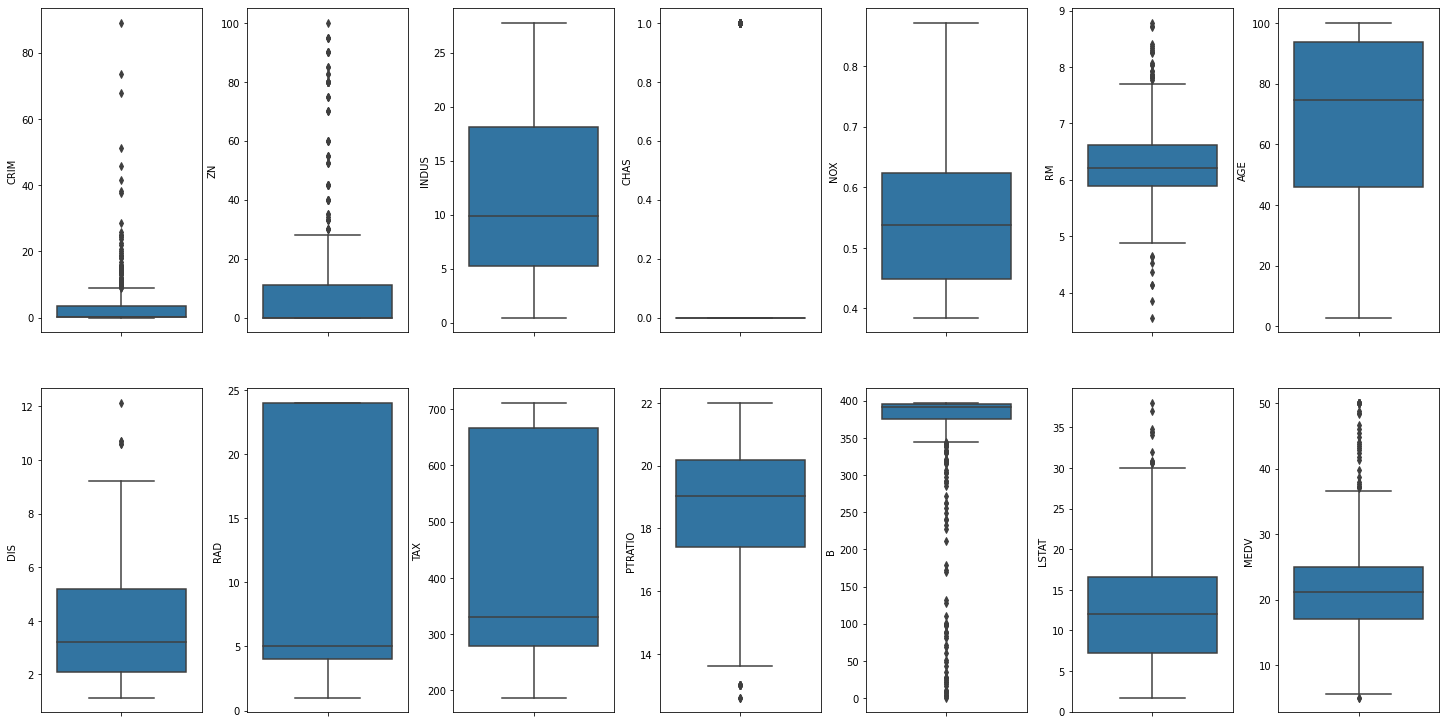

In [9]:
fig, axs = plt.subplots(ncols = 7, nrows = 2, figsize = (20, 10))
index = 0
axs = axs.flatten()
for a, b in boston.items():
    sns.boxplot(y = a, data = boston, ax = axs[index])
    index += 1
plt.tight_layout(pad = 0.4, w_pad = 0.5, h_pad = 5.0)

###### Create scatter plots to show relationships.  (Clue #3) Visualizing positive and negative linear relationships helps in determining feature selection.

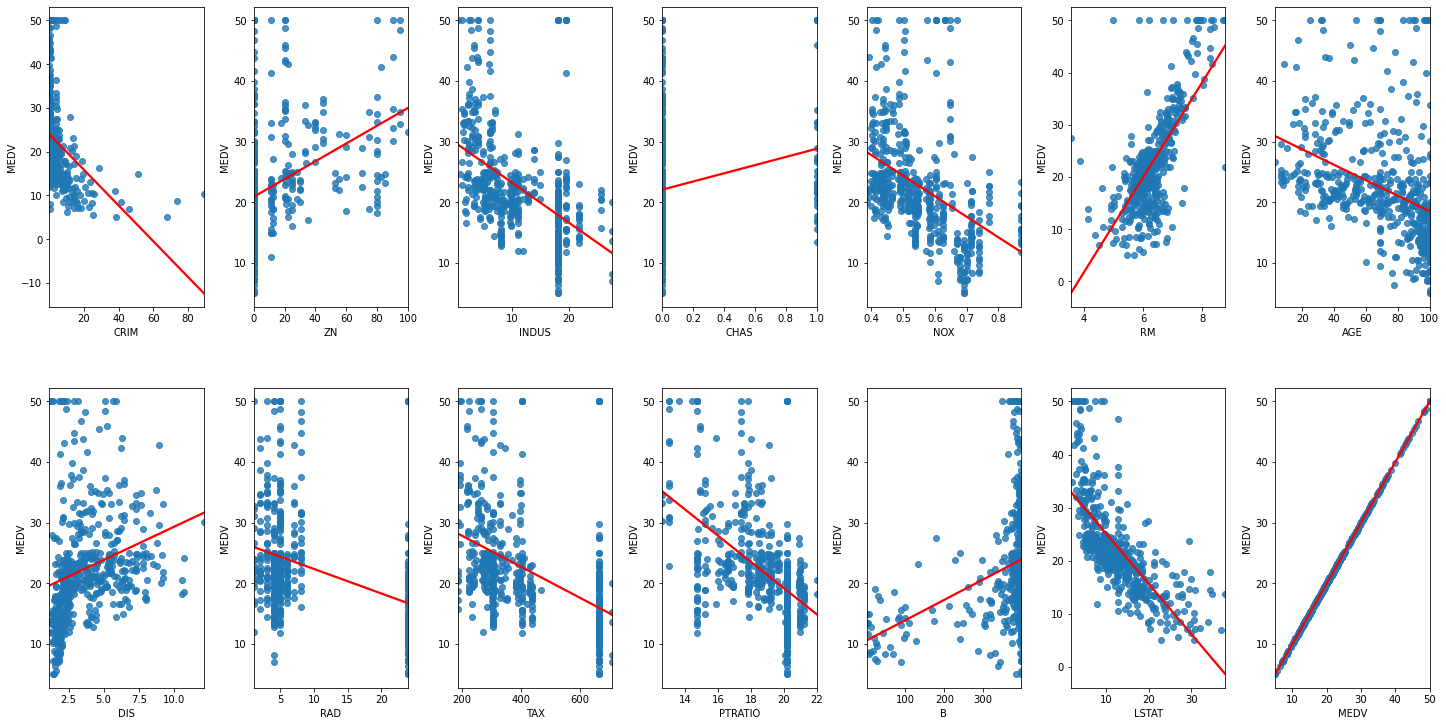

In [10]:
fig, axs = plt.subplots(ncols = 7, nrows = 2, figsize = (20, 10))
index = 0
axs = axs.flatten()
for a, b in boston.items():
    sns.regplot(x = boston[a], y = boston['MEDV'], ci = None, ax = axs[index], line_kws = {'color': 'red'})    
    index += 1
plt.tight_layout(pad = 0.4, w_pad = 0.5, h_pad = 5.0)

###### Create a corrleation matrix to solidify the final decision.  (Clue #4) Finding coefficients greater than 0.50 and less than -0.50 will be the determining factor in feature selection.  Only RM, PTRATIO, and LSTAT meet the criteria, so drop all the other features.

<AxesSubplot:>

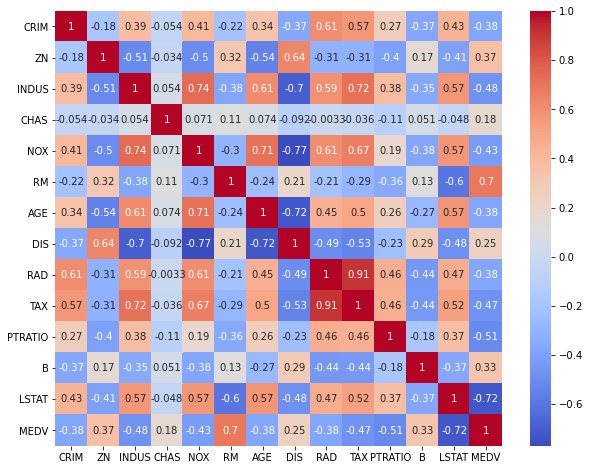

In [11]:
plt.figure(figsize = (10, 8))
sns.heatmap(boston.corr(), annot = True, cmap = 'coolwarm')

### Begin the Machine Learning

###### Prepare the data by separating the features (x) from the target (y).

In [12]:
x = pd.DataFrame(np.c_[boston['RM'], boston['PTRATIO'], boston['LSTAT']], columns = ('RM', 'PTRATIO', 'LSTAT'))
y = boston['MEDV']

###### Split the data into training and testing.

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, random_state = 17)

In [14]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(404, 3)
(102, 3)
(404,)
(102,)


###### Train the model.

In [15]:
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [16]:
y_predict = lr.predict(x_test)

###### Evaluate the Performance

In [17]:
print('R2Score = ', r2_score(y_test, y_predict))

R2Score =  0.6037249200646997


### Improving the Model - or not

###### Increase the coefficient threshold from 0.50 to 0.70.  In this experiment, the PTRATIO feature drops off.

In [18]:
x = pd.DataFrame(np.c_[boston['RM'], boston['LSTAT']], columns = ('RM', 'LSTAT'))
y = boston['MEDV']
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, random_state = 17)
lr.fit(x_train, y_train)
y_predict = lr.predict(x_test)
print('R2Score = ', r2_score(y_test, y_predict))

R2Score =  0.5685059217331393


###### Decrease the coefficient threshold from 0.50 to 0.40.  In this experiment, NOX, TAX, and INDUS are all added to the original mix.

In [19]:
x = pd.DataFrame(np.c_[boston['RM'], boston['LSTAT'], boston['NOX'], boston['TAX'], boston['INDUS']], columns = ('RM', 'LSTAT', 'NOX', 'TAX', 'INDUS'))
y = boston['MEDV']
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, random_state = 17)
lr.fit(x_train, y_train)
y_predict = lr.predict(x_test)
print('R2Score = ', r2_score(y_test, y_predict))

R2Score =  0.5863499298326478


### Normalization and Standardization

In [20]:
x = pd.DataFrame(np.c_[boston['RM'], boston['PTRATIO'], boston['LSTAT']], columns = ('RM', 'PTRATIO', 'LSTAT'))
y = boston['MEDV']
lr = LinearRegression(normalize = True)
lr.fit(x_train, y_train)
y_predict = lr.predict(x_test)
print('R2Score = ', r2_score(y_test, y_predict))

R2Score =  0.5863499298326462


In [21]:
def plot_learning_curve(estimator, title, x, y, ylim = None, cv = None, n_jobs = None, train_sizes = np.linspace(0.1, 1.0, 10)):
    plt.figure()
    plt.title(title)
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, x, y, cv = cv, n_jobs = n_jobs, train_sizes = train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)
    
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha = 0.1, color = 'r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha = 0.1, color = 'g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color = 'r', label = 'Training Score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color = 'g', label = 'Cross-Validation Score')
    
    plt.legend(loc = 'best')
    return plt

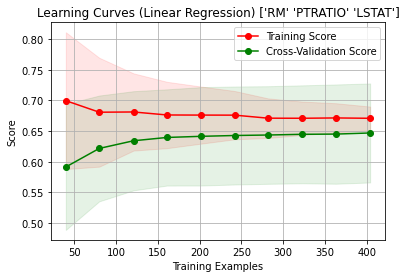

In [22]:
title = 'Learning Curves (Linear Regression) ' + str(x.columns.values)
cv = ShuffleSplit(n_splits = 100, test_size = 0.2, random_state = 17)
estimator = LinearRegression()
plot_learning_curve(estimator, title, x, y, ylim = (0.7, 1.01), cv = cv, n_jobs = 4)
plt.show()